# pre-process h5 output to get river face flux

In [1]:
import sys
sys.version

'3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:09:58) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [1]:
import numpy as np
import h5py as h5
import glob
import pickle

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta

In [2]:
def batch_time_to_delta(origin, x, time_format):
    y = []
    for ix in x:
        temp_y = abs(datetime.strptime(
            ix, time_format) - origin).total_seconds()
        y.append(temp_y)
    y = np.asarray(y)
    return(y)

def batch_delta_to_time(origin, x, time_format, delta_format):
    y = []
    for ix in x:
        if delta_format == "hours":
            temp_y = origin + timedelta(hours=ix)
        elif delta_format == "days":
            temp_y = origin + timedelta(days=ix)
        elif delta_format == "minutes":
            temp_y = origin + timedelta(minutes=ix)
        elif delta_format == "weeks":
            temp_y = origin + timedelta(weeks=ix)
        elif delta_format == "seconds":
            temp_y = origin + timedelta(seconds=ix)
        elif delta_format == "microseconds":
            temp_y = origin + timedelta(microseconds=ix)
        elif delta_format == "milliseconds":
            temp_y = origin + timedelta(milliseconds=ix)
        else:
            print("Sorry, this naive program only solve single time unit")
        y.append(temp_y.strftime(time_format))
    y = np.asarray(y)
    return(y)

## I/O files and model parameters

In [23]:
#input
# case_name = "HFR_model_200x200x2_head_bc_new_iniH/"
case_name = "HFR_model_100x100x2/"

model_dir = "/global/cscratch1/sd/pshuai/" + case_name

# fname_model_origin = model_dir + "model_origin.txt"
fname_material_h5 = model_dir + "HFR_material_river.h5"
# fname_pflotran_h5 = model_dir + "pflotran_200x200x2_6h_bc_new_iniH.h5"
# fname_mass_dat = model_dir + "pflotran_200x200x2_6h_bc_new_iniH-mas.dat"
fname_pflotran_h5 = model_dir + "pflotran_100x100x2_6h_bc.h5"
fname_mass_dat = model_dir + "pflotran_100x100x2_6h_bc-mas.dat"


out_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/Outputs/" + case_name
result_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/results/" + case_name
data_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/data/"

fname_usgs_gage = data_dir + "USGS_flow_gh_12472800.csv"
fname_mass1_coord = data_dir + "MASS1/coordinates.csv"
#output
fname_pickle = result_dir + "face_flux.pk"
fig_face_flux = out_dir + "face_flux/face_flux.png"
fig_face_snapshots = out_dir + "face_flux/"

fname_out_flux_all = result_dir + "out_flux_all.pk"

fname_river_middle = data_dir + "river_middle.csv"
fname_river_north = data_dir + "river_north.csv"
fname_river_south = data_dir + "river_south.csv"

# fname_flux_net_gaining = out_dir + "face_flux/flux_net_gain.txt"
# fname_flux_abs_exchange = out_dir + "face_flux/flux_abs_exchange.txt"
# fname_flux_abs_gaining = out_dir + "face_flux/flux_abs_gain.txt"
# fname_flux_abs_losing = out_dir + "face_flux/flux_abs_lose.txt"

In [4]:
date_origin = datetime.strptime("2007-03-28 12:00:00", "%Y-%m-%d %H:%M:%S")

# model_origin = np.genfromtxt(fname_model_origin, delimiter=" ", skip_header=1)
model_origin = [551600, 104500]

In [5]:
# read mass1 coordinates
section_coord = np.genfromtxt(
    fname_mass1_coord, delimiter=",", skip_header=1)

section_coord[:, 1] = section_coord[:, 1] - model_origin[0]
section_coord[:, 2] = section_coord[:, 2] - model_origin[1]
# subtract last mass1 location to get length for each segment
mass1_length = section_coord[:, 4] - section_coord[-1, 4]

In [6]:
# middle block
block_middle_coord = np.genfromtxt(fname_river_middle, delimiter=",", skip_header=1)
block_middle_x = [(np.min(block_middle_coord[:, 1]) - model_origin[0]) / 1000,
           (np.max(block_middle_coord[:, 1]) - model_origin[0]) / 1000]

block_middle_y = [(np.min(block_middle_coord[:, 2]) - model_origin[1]) / 1000,
           (np.max(block_middle_coord[:, 2]) - model_origin[1]) / 1000]
# north block
block_north_coord = np.genfromtxt(fname_river_north, delimiter=",", skip_header=1)
block_north_x = [(np.min(block_north_coord[:, 1]) - model_origin[0]) / 1000,
           (np.max(block_north_coord[:, 1]) - model_origin[0]) / 1000]

block_north_y = [(np.min(block_north_coord[:, 2]) - model_origin[1]) / 1000,
           (np.max(block_north_coord[:, 2]) - model_origin[1]) / 1000]
# south block
block_south_coord = np.genfromtxt(fname_river_south, delimiter=",", skip_header=1)
block_south_x = [(np.min(block_south_coord[:, 1]) - model_origin[0]) / 1000,
           (np.max(block_south_coord[:, 1]) - model_origin[0]) / 1000]

block_south_y = [(np.min(block_south_coord[:, 2]) - model_origin[1]) / 1000,
           (np.max(block_south_coord[:, 2]) - model_origin[1]) / 1000]

**read output .h5 file**

In [7]:
input_h5 = h5.File(fname_pflotran_h5, "r")
x_grids = list(input_h5["Coordinates"]['X [m]'])
y_grids = list(input_h5["Coordinates"]['Y [m]'])
z_grids = list(input_h5["Coordinates"]['Z [m]'])
input_h5.close()

In [8]:
dx = np.diff(x_grids)
dy = np.diff(y_grids)
dz = np.diff(z_grids)

nx = len(dx)
ny = len(dy)
nz = len(dz)
x = x_grids[0] + np.cumsum(dx) - 0.5 * dx[0]
y = y_grids[0] + np.cumsum(dy) - 0.5 * dy[0]
z = z_grids[0] + np.cumsum(dz) - 0.5 * dz[0]

# store cell x, y, z--ids
grids = np.asarray([(x, y, z) for z in range(nz)
                    for y in range(ny) for x in range(nx)])

# calculate cell face area (m2)
west_area = dy[0] * dz[0]
east_area = dy[0] * dz[0]
south_area = dx[0] * dz[0]
north_area = dx[0] * dz[0]
top_area = dx[0] * dy[0]
bottom_area = dx[0] * dy[0]

**read material.h5 file**

In [9]:
material_h5 = h5.File(fname_material_h5, "r")

# all_h5 = glob.glob(model_dir + "pflotran*h5")
# all_h5 = np.sort(all_h5)

# read river face information
river_cells = []
river_faces = []
for i_region in list(material_h5['Regions'].keys()):
    river_cells = np.append(river_cells, np.asarray(
        list(material_h5["Regions"][i_region]["Cell Ids"])))
    river_faces = np.append(river_faces, np.asarray(
        list(material_h5["Regions"][i_region]["Face Ids"])))
river_cells = river_cells.astype(int)
river_cells = river_cells - 1  # need minus 1 as python index started with 0
river_faces = river_faces.astype(int)

unique_river_cells = np.unique(river_cells)

material_h5.close()

**find river cells not on the model boundary**

In [11]:
temp_unique_river_cells = unique_river_cells
unique_river_cells = []
north_river_cells = []
middle_river_cells = []
south_river_cells = []


# store river cells that are not on the model domain boundaries (no face flux calculated at the boundary)
for i_cell in temp_unique_river_cells:
    if (grids[i_cell, 0] > 0 and grids[i_cell, 0] < (nx - 1) and
            grids[i_cell, 1] > 0 and grids[i_cell, 1] < (ny - 1) and
            grids[i_cell, 2] > 0 and grids[i_cell, 2] < (nz - 1)):
        unique_river_cells.append(i_cell)
    if (grids[i_cell, 0] > block_north_x[0]*10 and grids[i_cell, 0] < block_north_x[1]*10 and
            grids[i_cell, 1] > block_north_y[0]*10 and grids[i_cell, 1] < block_north_y[1]*10 and
            grids[i_cell, 2] > 0 and grids[i_cell, 2] < (nz - 1)):
        north_river_cells.append(i_cell)
    if (grids[i_cell, 0] > block_middle_x[0]*10 and grids[i_cell, 0] < block_middle_x[1]*10 and
        grids[i_cell, 1] > block_middle_y[0]*10 and grids[i_cell, 1] < block_middle_y[1]*10 and
        grids[i_cell, 2] > 0 and grids[i_cell, 2] < (nz - 1)):
        middle_river_cells.append(i_cell)
    if (grids[i_cell, 0] > block_south_x[0]*10 and grids[i_cell, 0] < block_south_x[1]*10 and
        grids[i_cell, 1] > block_south_y[0]*10 and grids[i_cell, 1] < block_south_y[1]*10 and
        grids[i_cell, 2] > 0 and grids[i_cell, 2] < (nz - 1)):
        south_river_cells.append(i_cell)

n_unique = len(unique_river_cells)
unique_index = [grids[i, :] for i in unique_river_cells]
unique_index_north = [grids[i, :] for i in north_river_cells]
unique_index_middle = [grids[i, :] for i in middle_river_cells]
unique_index_south = [grids[i, :] for i in south_river_cells]


unique_xy = [grids[i, 0:2] for i in unique_river_cells]
unique_xy = np.asarray(unique_xy)

**find faces of a cell that are "river face" and assign 1 to them**

In [12]:
river_face_array = np.array([], dtype=np.float).reshape(0, 6) # total six faces of a cell
for i_cell in unique_river_cells:
    temp_face_vector = np.array([0] * 6).reshape(1, 6)
    temp_faces = river_faces[river_cells == i_cell]
    for iface in list(map(int, temp_faces)):
        temp_face_vector[0, iface - 1] = 1 # assign 1 to river face
    river_face_array = np.concatenate(
        (river_face_array, temp_face_vector), axis=0)

In [13]:
river_face_array_north = np.array([], dtype=np.float).reshape(0, 6) # total six faces of a cell
for i_cell in north_river_cells:
    temp_face_vector = np.array([0] * 6).reshape(1, 6)
    temp_faces = river_faces[river_cells == i_cell]
    for iface in list(map(int, temp_faces)):
        temp_face_vector[0, iface - 1] = 1 # assign 1 to river face
    river_face_array_north = np.concatenate(
        (river_face_array_north, temp_face_vector), axis=0)

In [14]:
river_face_array_middle = np.array([], dtype=np.float).reshape(0, 6) # total six faces of a cell
for i_cell in middle_river_cells:
    temp_face_vector = np.array([0] * 6).reshape(1, 6)
    temp_faces = river_faces[river_cells == i_cell]
    for iface in list(map(int, temp_faces)):
        temp_face_vector[0, iface - 1] = 1 # assign 1 to river face
    river_face_array_middle = np.concatenate(
        (river_face_array_middle, temp_face_vector), axis=0)

In [15]:
river_face_array_south = np.array([], dtype=np.float).reshape(0, 6) # total six faces of a cell
for i_cell in south_river_cells:
    temp_face_vector = np.array([0] * 6).reshape(1, 6)
    temp_faces = river_faces[river_cells == i_cell]
    for iface in list(map(int, temp_faces)):
        temp_face_vector[0, iface - 1] = 1 # assign 1 to river face
    river_face_array_south = np.concatenate(
        (river_face_array_south, temp_face_vector), axis=0)

## calculate outflux (flux across river cell face)

### calculate flux for the whole reach

In [12]:
out_flux = {}
# all_h5 = glob.glob(model_dir + "pflotran*h5")
# for i_h5 in all_h5:
#     print(i_h5)
h5file = h5.File(fname_pflotran_h5, "r")
groups = list(h5file.keys())
time_index = [i for i, s in enumerate(groups) if "Time:" in s]
times = [groups[i] for i in time_index]

for itime in times:
    print(itime)

    # get dict of all flux
    x_darcy = np.asarray(list(h5file[itime]["Liquid X-Flux Velocities"])) # m/h?
    y_darcy = np.asarray(list(h5file[itime]["Liquid Y-Flux Velocities"]))
    z_darcy = np.asarray(list(h5file[itime]["Liquid Z-Flux Velocities"]))

    # get flux on all cell face in river bed cells, i[0]--cell id in x direction; 
    # i[1]--cell id in y direction; i[2]--cell id in z direction
    west_flux = [x_darcy[i[0] - 1, i[1], i[2]] for i in unique_index] # why - 1 ? west flux is from cell before current one (i.e on the left handside)
    east_flux = [x_darcy[i[0], i[1], i[2]] for i in unique_index]
    south_flux = [y_darcy[i[0], i[1] - 1, i[2]] for i in unique_index]
    north_flux = [y_darcy[i[0], i[1], i[2]] for i in unique_index]
    bottom_flux = [z_darcy[i[0], i[1], i[2] - 1] for i in unique_index]
    top_flux = [z_darcy[i[0], i[1], i[2]] for i in unique_index]

    # get volumeric flux--m3/h
    west_flux = [x * west_area for x in west_flux]
    east_flux = [x * east_area for x in east_flux]
    south_flux = [x * south_area for x in south_flux]
    north_flux = [x * north_area for x in north_flux]
    bottom_flux = [x * bottom_area for x in bottom_flux]
    top_flux = [x * top_area for x in top_flux]

    # get flux on river face of river cells, river_face_array contains 0 and 1
    river_face_flux = river_face_array * np.column_stack(
        (west_flux, east_flux, south_flux,
         north_flux, bottom_flux, top_flux))

    # combine x,y,z directions to get outflow flux = west_flux [x[0]] + east_flux + south_flux + north_flux + bottom_flux + top_flux
    out_flux[itime] = [(-x[0] + x[1] - x[2] + x[3] - x[4] + x[5])
                       for x in river_face_flux]

Time:  3.24000E+04 h
Time:  3.24060E+04 h
Time:  3.24120E+04 h
Time:  3.24180E+04 h
Time:  3.24240E+04 h
Time:  3.24300E+04 h
Time:  3.24360E+04 h
Time:  3.24420E+04 h
Time:  3.24480E+04 h
Time:  3.24540E+04 h
Time:  3.24600E+04 h
Time:  3.24660E+04 h
Time:  3.24720E+04 h
Time:  3.24780E+04 h
Time:  3.24840E+04 h
Time:  3.24900E+04 h
Time:  3.24960E+04 h
Time:  3.25020E+04 h
Time:  3.25080E+04 h
Time:  3.25140E+04 h
Time:  3.25200E+04 h
Time:  3.25260E+04 h
Time:  3.25320E+04 h
Time:  3.25380E+04 h
Time:  3.25440E+04 h
Time:  3.25500E+04 h
Time:  3.25560E+04 h
Time:  3.25620E+04 h
Time:  3.25680E+04 h
Time:  3.25740E+04 h
Time:  3.25800E+04 h
Time:  3.25860E+04 h
Time:  3.25920E+04 h
Time:  3.25980E+04 h
Time:  3.26040E+04 h
Time:  3.26100E+04 h
Time:  3.26160E+04 h
Time:  3.26220E+04 h
Time:  3.26280E+04 h
Time:  3.26340E+04 h
Time:  3.26400E+04 h
Time:  3.26460E+04 h
Time:  3.26520E+04 h
Time:  3.26580E+04 h
Time:  3.26640E+04 h
Time:  3.26700E+04 h
Time:  3.26760E+04 h
Time:  3.2682

Time:  3.51300E+04 h
Time:  3.51360E+04 h
Time:  3.51420E+04 h
Time:  3.51480E+04 h
Time:  3.51540E+04 h
Time:  3.51600E+04 h
Time:  3.51660E+04 h
Time:  3.51720E+04 h
Time:  3.51780E+04 h
Time:  3.51840E+04 h
Time:  3.51900E+04 h
Time:  3.51960E+04 h
Time:  3.52020E+04 h
Time:  3.52080E+04 h
Time:  3.52140E+04 h
Time:  3.52200E+04 h
Time:  3.52260E+04 h
Time:  3.52320E+04 h
Time:  3.52380E+04 h
Time:  3.52440E+04 h
Time:  3.52500E+04 h
Time:  3.52560E+04 h
Time:  3.52620E+04 h
Time:  3.52680E+04 h
Time:  3.52740E+04 h
Time:  3.52800E+04 h
Time:  3.52860E+04 h
Time:  3.52920E+04 h
Time:  3.52980E+04 h
Time:  3.53040E+04 h
Time:  3.53100E+04 h
Time:  3.53160E+04 h
Time:  3.53220E+04 h
Time:  3.53280E+04 h
Time:  3.53340E+04 h
Time:  3.53400E+04 h
Time:  3.53460E+04 h
Time:  3.53520E+04 h
Time:  3.53580E+04 h
Time:  3.53640E+04 h
Time:  3.53700E+04 h
Time:  3.53760E+04 h
Time:  3.53820E+04 h
Time:  3.53880E+04 h
Time:  3.53940E+04 h
Time:  3.54000E+04 h
Time:  3.54060E+04 h
Time:  3.5412

Time:  3.74760E+04 h
Time:  3.74820E+04 h
Time:  3.74880E+04 h
Time:  3.74940E+04 h
Time:  3.75000E+04 h
Time:  3.75060E+04 h
Time:  3.75120E+04 h
Time:  3.75180E+04 h
Time:  3.75240E+04 h
Time:  3.75300E+04 h
Time:  3.75360E+04 h
Time:  3.75420E+04 h
Time:  3.75480E+04 h
Time:  3.75540E+04 h
Time:  3.75600E+04 h
Time:  3.75660E+04 h
Time:  3.75720E+04 h
Time:  3.75780E+04 h
Time:  3.75840E+04 h
Time:  3.75900E+04 h
Time:  3.75960E+04 h
Time:  3.76020E+04 h
Time:  3.76080E+04 h
Time:  3.76140E+04 h
Time:  3.76200E+04 h
Time:  3.76260E+04 h
Time:  3.76320E+04 h
Time:  3.76380E+04 h
Time:  3.76440E+04 h
Time:  3.76500E+04 h
Time:  3.76560E+04 h
Time:  3.76620E+04 h
Time:  3.76680E+04 h
Time:  3.76740E+04 h
Time:  3.76800E+04 h
Time:  3.76860E+04 h
Time:  3.76920E+04 h
Time:  3.76980E+04 h
Time:  3.77040E+04 h
Time:  3.77100E+04 h
Time:  3.77160E+04 h
Time:  3.77220E+04 h
Time:  3.77280E+04 h
Time:  3.77340E+04 h
Time:  3.77400E+04 h
Time:  3.77460E+04 h
Time:  3.77520E+04 h
Time:  3.7758

Time:  3.98220E+04 h
Time:  3.98280E+04 h
Time:  3.98340E+04 h
Time:  3.98400E+04 h
Time:  3.98460E+04 h
Time:  3.98520E+04 h
Time:  3.98580E+04 h
Time:  3.98640E+04 h
Time:  3.98700E+04 h
Time:  3.98760E+04 h
Time:  3.98820E+04 h
Time:  3.98880E+04 h
Time:  3.98940E+04 h
Time:  3.99000E+04 h
Time:  3.99060E+04 h
Time:  3.99120E+04 h
Time:  3.99180E+04 h
Time:  3.99240E+04 h
Time:  3.99300E+04 h
Time:  3.99360E+04 h
Time:  3.99420E+04 h
Time:  3.99480E+04 h
Time:  3.99540E+04 h
Time:  3.99600E+04 h
Time:  3.99660E+04 h
Time:  3.99720E+04 h
Time:  3.99780E+04 h
Time:  3.99840E+04 h
Time:  3.99900E+04 h
Time:  3.99960E+04 h
Time:  4.00020E+04 h
Time:  4.00080E+04 h
Time:  4.00140E+04 h
Time:  4.00200E+04 h
Time:  4.00260E+04 h
Time:  4.00320E+04 h
Time:  4.00380E+04 h
Time:  4.00440E+04 h
Time:  4.00500E+04 h
Time:  4.00560E+04 h
Time:  4.00620E+04 h
Time:  4.00680E+04 h
Time:  4.00740E+04 h
Time:  4.00800E+04 h
Time:  4.00860E+04 h
Time:  4.00920E+04 h
Time:  4.00980E+04 h
Time:  4.0104

Time:  4.21680E+04 h
Time:  4.21740E+04 h
Time:  4.21800E+04 h
Time:  4.21860E+04 h
Time:  4.21920E+04 h
Time:  4.21980E+04 h
Time:  4.22040E+04 h
Time:  4.22100E+04 h
Time:  4.22160E+04 h
Time:  4.22220E+04 h
Time:  4.22280E+04 h
Time:  4.22340E+04 h
Time:  4.22400E+04 h
Time:  4.22460E+04 h
Time:  4.22520E+04 h
Time:  4.22580E+04 h
Time:  4.22640E+04 h
Time:  4.22700E+04 h
Time:  4.22760E+04 h
Time:  4.22820E+04 h
Time:  4.22880E+04 h
Time:  4.22940E+04 h
Time:  4.23000E+04 h
Time:  4.23060E+04 h
Time:  4.23120E+04 h
Time:  4.23180E+04 h
Time:  4.23240E+04 h
Time:  4.23300E+04 h
Time:  4.23360E+04 h
Time:  4.23420E+04 h
Time:  4.23480E+04 h
Time:  4.23540E+04 h
Time:  4.23600E+04 h
Time:  4.23660E+04 h
Time:  4.23720E+04 h
Time:  4.23780E+04 h
Time:  4.23840E+04 h
Time:  4.23900E+04 h
Time:  4.23960E+04 h
Time:  4.24020E+04 h
Time:  4.24080E+04 h
Time:  4.24140E+04 h
Time:  4.24200E+04 h
Time:  4.24260E+04 h
Time:  4.24320E+04 h
Time:  4.24380E+04 h
Time:  4.24440E+04 h
Time:  4.2450

Time:  4.45140E+04 h
Time:  4.45200E+04 h
Time:  4.45260E+04 h
Time:  4.45320E+04 h
Time:  4.45380E+04 h
Time:  4.45440E+04 h
Time:  4.45500E+04 h
Time:  4.45560E+04 h
Time:  4.45620E+04 h
Time:  4.45680E+04 h
Time:  4.45740E+04 h
Time:  4.45800E+04 h
Time:  4.45860E+04 h
Time:  4.45920E+04 h
Time:  4.45980E+04 h
Time:  4.46040E+04 h
Time:  4.46100E+04 h
Time:  4.46160E+04 h
Time:  4.46220E+04 h
Time:  4.46280E+04 h
Time:  4.46340E+04 h
Time:  4.46400E+04 h
Time:  4.46460E+04 h
Time:  4.46520E+04 h
Time:  4.46580E+04 h
Time:  4.46640E+04 h
Time:  4.46700E+04 h
Time:  4.46760E+04 h
Time:  4.46820E+04 h
Time:  4.46880E+04 h
Time:  4.46940E+04 h
Time:  4.47000E+04 h
Time:  4.47060E+04 h
Time:  4.47120E+04 h
Time:  4.47180E+04 h
Time:  4.47240E+04 h
Time:  4.47300E+04 h
Time:  4.47360E+04 h
Time:  4.47420E+04 h
Time:  4.47480E+04 h
Time:  4.47540E+04 h
Time:  4.47600E+04 h
Time:  4.47660E+04 h
Time:  4.47720E+04 h
Time:  4.47780E+04 h
Time:  4.47840E+04 h
Time:  4.47900E+04 h
Time:  4.4796

Time:  4.68600E+04 h
Time:  4.68660E+04 h
Time:  4.68720E+04 h
Time:  4.68780E+04 h
Time:  4.68840E+04 h
Time:  4.68900E+04 h
Time:  4.68960E+04 h
Time:  4.69020E+04 h
Time:  4.69080E+04 h
Time:  4.69140E+04 h
Time:  4.69200E+04 h
Time:  4.69260E+04 h
Time:  4.69320E+04 h
Time:  4.69380E+04 h
Time:  4.69440E+04 h
Time:  4.69500E+04 h
Time:  4.69560E+04 h
Time:  4.69620E+04 h
Time:  4.69680E+04 h
Time:  4.69740E+04 h
Time:  4.69800E+04 h
Time:  4.69860E+04 h
Time:  4.69920E+04 h
Time:  4.69980E+04 h
Time:  4.70040E+04 h
Time:  4.70100E+04 h
Time:  4.70160E+04 h
Time:  4.70220E+04 h
Time:  4.70280E+04 h
Time:  4.70340E+04 h
Time:  4.70400E+04 h
Time:  4.70460E+04 h
Time:  4.70520E+04 h
Time:  4.70580E+04 h
Time:  4.70640E+04 h
Time:  4.70700E+04 h
Time:  4.70760E+04 h
Time:  4.70820E+04 h
Time:  4.70880E+04 h
Time:  4.70940E+04 h
Time:  4.71000E+04 h
Time:  4.71060E+04 h
Time:  4.71120E+04 h
Time:  4.71180E+04 h
Time:  4.71240E+04 h
Time:  4.71300E+04 h
Time:  4.71360E+04 h
Time:  4.7142

Time:  4.92060E+04 h
Time:  4.92120E+04 h
Time:  4.92180E+04 h
Time:  4.92240E+04 h
Time:  4.92300E+04 h
Time:  4.92360E+04 h
Time:  4.92420E+04 h
Time:  4.92480E+04 h
Time:  4.92540E+04 h
Time:  4.92600E+04 h
Time:  4.92660E+04 h
Time:  4.92720E+04 h
Time:  4.92780E+04 h
Time:  4.92840E+04 h
Time:  4.92900E+04 h
Time:  4.92960E+04 h
Time:  4.93020E+04 h
Time:  4.93080E+04 h
Time:  4.93140E+04 h
Time:  4.93200E+04 h
Time:  4.93260E+04 h
Time:  4.93320E+04 h
Time:  4.93380E+04 h
Time:  4.93440E+04 h
Time:  4.93500E+04 h
Time:  4.93560E+04 h
Time:  4.93620E+04 h
Time:  4.93680E+04 h
Time:  4.93740E+04 h
Time:  4.93800E+04 h
Time:  4.93860E+04 h
Time:  4.93920E+04 h
Time:  4.93980E+04 h
Time:  4.94040E+04 h
Time:  4.94100E+04 h
Time:  4.94160E+04 h
Time:  4.94220E+04 h
Time:  4.94280E+04 h
Time:  4.94340E+04 h
Time:  4.94400E+04 h
Time:  4.94460E+04 h
Time:  4.94520E+04 h
Time:  4.94580E+04 h
Time:  4.94640E+04 h
Time:  4.94700E+04 h
Time:  4.94760E+04 h
Time:  4.94820E+04 h
Time:  4.9488

Time:  5.15520E+04 h
Time:  5.15580E+04 h
Time:  5.15640E+04 h
Time:  5.15700E+04 h
Time:  5.15760E+04 h
Time:  5.15820E+04 h
Time:  5.15880E+04 h
Time:  5.15940E+04 h
Time:  5.16000E+04 h
Time:  5.16060E+04 h
Time:  5.16120E+04 h
Time:  5.16180E+04 h
Time:  5.16240E+04 h
Time:  5.16300E+04 h
Time:  5.16360E+04 h
Time:  5.16420E+04 h
Time:  5.16480E+04 h
Time:  5.16540E+04 h
Time:  5.16600E+04 h
Time:  5.16660E+04 h
Time:  5.16720E+04 h
Time:  5.16780E+04 h
Time:  5.16840E+04 h
Time:  5.16900E+04 h
Time:  5.16960E+04 h
Time:  5.17020E+04 h
Time:  5.17080E+04 h
Time:  5.17140E+04 h
Time:  5.17200E+04 h
Time:  5.17260E+04 h
Time:  5.17320E+04 h
Time:  5.17380E+04 h
Time:  5.17440E+04 h
Time:  5.17500E+04 h
Time:  5.17560E+04 h
Time:  5.17620E+04 h
Time:  5.17680E+04 h
Time:  5.17740E+04 h
Time:  5.17800E+04 h
Time:  5.17860E+04 h
Time:  5.17920E+04 h
Time:  5.17980E+04 h
Time:  5.18040E+04 h
Time:  5.18100E+04 h
Time:  5.18160E+04 h
Time:  5.18220E+04 h
Time:  5.18280E+04 h
Time:  5.1834

Time:  5.38980E+04 h
Time:  5.39040E+04 h
Time:  5.39100E+04 h
Time:  5.39160E+04 h
Time:  5.39220E+04 h
Time:  5.39280E+04 h
Time:  5.39340E+04 h
Time:  5.39400E+04 h
Time:  5.39460E+04 h
Time:  5.39520E+04 h
Time:  5.39580E+04 h
Time:  5.39640E+04 h
Time:  5.39700E+04 h
Time:  5.39760E+04 h
Time:  5.39820E+04 h
Time:  5.39880E+04 h
Time:  5.39940E+04 h
Time:  5.40000E+04 h
Time:  5.40060E+04 h
Time:  5.40120E+04 h
Time:  5.40180E+04 h
Time:  5.40240E+04 h
Time:  5.40300E+04 h
Time:  5.40360E+04 h
Time:  5.40420E+04 h
Time:  5.40480E+04 h
Time:  5.40540E+04 h
Time:  5.40600E+04 h
Time:  5.40660E+04 h
Time:  5.40720E+04 h
Time:  5.40780E+04 h
Time:  5.40840E+04 h
Time:  5.40900E+04 h
Time:  5.40960E+04 h
Time:  5.41020E+04 h
Time:  5.41080E+04 h
Time:  5.41140E+04 h
Time:  5.41200E+04 h
Time:  5.41260E+04 h
Time:  5.41320E+04 h
Time:  5.41380E+04 h
Time:  5.41440E+04 h
Time:  5.41500E+04 h
Time:  5.41560E+04 h
Time:  5.41620E+04 h
Time:  5.41680E+04 h
Time:  5.41740E+04 h
Time:  5.4180

Time:  5.62440E+04 h
Time:  5.62500E+04 h
Time:  5.62560E+04 h
Time:  5.62620E+04 h
Time:  5.62680E+04 h
Time:  5.62740E+04 h
Time:  5.62800E+04 h
Time:  5.62860E+04 h
Time:  5.62920E+04 h
Time:  5.62980E+04 h
Time:  5.63040E+04 h
Time:  5.63100E+04 h
Time:  5.63160E+04 h
Time:  5.63220E+04 h
Time:  5.63280E+04 h
Time:  5.63340E+04 h
Time:  5.63400E+04 h
Time:  5.63460E+04 h
Time:  5.63520E+04 h
Time:  5.63580E+04 h
Time:  5.63640E+04 h
Time:  5.63700E+04 h
Time:  5.63760E+04 h
Time:  5.63820E+04 h
Time:  5.63880E+04 h
Time:  5.63940E+04 h
Time:  5.64000E+04 h
Time:  5.64060E+04 h
Time:  5.64120E+04 h
Time:  5.64180E+04 h
Time:  5.64240E+04 h
Time:  5.64300E+04 h
Time:  5.64360E+04 h
Time:  5.64420E+04 h
Time:  5.64480E+04 h
Time:  5.64540E+04 h
Time:  5.64600E+04 h
Time:  5.64660E+04 h
Time:  5.64720E+04 h
Time:  5.64780E+04 h
Time:  5.64840E+04 h
Time:  5.64900E+04 h
Time:  5.64960E+04 h
Time:  5.65020E+04 h
Time:  5.65080E+04 h
Time:  5.65140E+04 h
Time:  5.65200E+04 h
Time:  5.6526

Time:  5.85900E+04 h
Time:  5.85960E+04 h
Time:  5.86020E+04 h
Time:  5.86080E+04 h
Time:  5.86140E+04 h
Time:  5.86200E+04 h
Time:  5.86260E+04 h
Time:  5.86320E+04 h
Time:  5.86380E+04 h
Time:  5.86440E+04 h
Time:  5.86500E+04 h
Time:  5.86560E+04 h
Time:  5.86620E+04 h
Time:  5.86680E+04 h
Time:  5.86740E+04 h
Time:  5.86800E+04 h
Time:  5.86860E+04 h
Time:  5.86920E+04 h
Time:  5.86980E+04 h
Time:  5.87040E+04 h
Time:  5.87100E+04 h
Time:  5.87160E+04 h
Time:  5.87220E+04 h
Time:  5.87280E+04 h
Time:  5.87340E+04 h
Time:  5.87400E+04 h
Time:  5.87460E+04 h
Time:  5.87520E+04 h
Time:  5.87580E+04 h
Time:  5.87640E+04 h
Time:  5.87700E+04 h
Time:  5.87760E+04 h
Time:  5.87820E+04 h
Time:  5.87880E+04 h
Time:  5.87940E+04 h
Time:  5.88000E+04 h
Time:  5.88060E+04 h
Time:  5.88120E+04 h
Time:  5.88180E+04 h
Time:  5.88240E+04 h
Time:  5.88300E+04 h
Time:  5.88360E+04 h
Time:  5.88420E+04 h
Time:  5.88480E+04 h
Time:  5.88540E+04 h
Time:  5.88600E+04 h
Time:  5.88660E+04 h
Time:  5.8872

Time:  6.09360E+04 h
Time:  6.09420E+04 h
Time:  6.09480E+04 h
Time:  6.09540E+04 h
Time:  6.09600E+04 h
Time:  6.09660E+04 h
Time:  6.09720E+04 h
Time:  6.09780E+04 h
Time:  6.09840E+04 h
Time:  6.09900E+04 h
Time:  6.09960E+04 h
Time:  6.10020E+04 h
Time:  6.10080E+04 h
Time:  6.10140E+04 h
Time:  6.10200E+04 h
Time:  6.10260E+04 h
Time:  6.10320E+04 h
Time:  6.10380E+04 h
Time:  6.10440E+04 h
Time:  6.10500E+04 h
Time:  6.10560E+04 h
Time:  6.10620E+04 h
Time:  6.10680E+04 h
Time:  6.10740E+04 h
Time:  6.10800E+04 h
Time:  6.10860E+04 h
Time:  6.10920E+04 h
Time:  6.10980E+04 h
Time:  6.11040E+04 h
Time:  6.11100E+04 h
Time:  6.11160E+04 h
Time:  6.11220E+04 h
Time:  6.11280E+04 h
Time:  6.11340E+04 h
Time:  6.11400E+04 h
Time:  6.11460E+04 h
Time:  6.11520E+04 h
Time:  6.11580E+04 h
Time:  6.11640E+04 h
Time:  6.11700E+04 h
Time:  6.11760E+04 h
Time:  6.11820E+04 h
Time:  6.11880E+04 h
Time:  6.11940E+04 h
Time:  6.12000E+04 h
Time:  6.12060E+04 h
Time:  6.12120E+04 h
Time:  6.1218

Time:  6.32820E+04 h
Time:  6.32880E+04 h
Time:  6.32940E+04 h
Time:  6.33000E+04 h
Time:  6.33060E+04 h
Time:  6.33120E+04 h
Time:  6.33180E+04 h
Time:  6.33240E+04 h
Time:  6.33300E+04 h
Time:  6.33360E+04 h
Time:  6.33420E+04 h
Time:  6.33480E+04 h
Time:  6.33540E+04 h
Time:  6.33600E+04 h
Time:  6.33660E+04 h
Time:  6.33720E+04 h
Time:  6.33780E+04 h
Time:  6.33840E+04 h
Time:  6.33900E+04 h
Time:  6.33960E+04 h
Time:  6.34020E+04 h
Time:  6.34080E+04 h
Time:  6.34140E+04 h
Time:  6.34200E+04 h
Time:  6.34260E+04 h
Time:  6.34320E+04 h
Time:  6.34380E+04 h
Time:  6.34440E+04 h
Time:  6.34500E+04 h
Time:  6.34560E+04 h
Time:  6.34620E+04 h
Time:  6.34680E+04 h
Time:  6.34740E+04 h
Time:  6.34800E+04 h
Time:  6.34860E+04 h
Time:  6.34920E+04 h
Time:  6.34980E+04 h
Time:  6.35040E+04 h
Time:  6.35100E+04 h
Time:  6.35160E+04 h
Time:  6.35220E+04 h
Time:  6.35280E+04 h
Time:  6.35340E+04 h
Time:  6.35400E+04 h
Time:  6.35460E+04 h
Time:  6.35520E+04 h
Time:  6.35580E+04 h
Time:  6.3564

Time:  6.56280E+04 h
Time:  6.56340E+04 h
Time:  6.56400E+04 h
Time:  6.56460E+04 h
Time:  6.56520E+04 h
Time:  6.56580E+04 h
Time:  6.56640E+04 h
Time:  6.56700E+04 h
Time:  6.56760E+04 h
Time:  6.56820E+04 h
Time:  6.56880E+04 h
Time:  6.56940E+04 h
Time:  6.57000E+04 h
Time:  6.57060E+04 h
Time:  6.57120E+04 h
Time:  6.57180E+04 h
Time:  6.57240E+04 h
Time:  6.57300E+04 h
Time:  6.57360E+04 h
Time:  6.57420E+04 h
Time:  6.57480E+04 h
Time:  6.57540E+04 h
Time:  6.57600E+04 h
Time:  6.57660E+04 h
Time:  6.57720E+04 h
Time:  6.57780E+04 h
Time:  6.57840E+04 h
Time:  6.57900E+04 h
Time:  6.57960E+04 h
Time:  6.58020E+04 h
Time:  6.58080E+04 h
Time:  6.58140E+04 h
Time:  6.58200E+04 h
Time:  6.58260E+04 h
Time:  6.58320E+04 h
Time:  6.58380E+04 h
Time:  6.58440E+04 h
Time:  6.58500E+04 h
Time:  6.58560E+04 h
Time:  6.58620E+04 h
Time:  6.58680E+04 h
Time:  6.58740E+04 h
Time:  6.58800E+04 h
Time:  6.58860E+04 h
Time:  6.58920E+04 h
Time:  6.58980E+04 h
Time:  6.59040E+04 h
Time:  6.5910

**store pickle file**

In [13]:
file = open(fname_pickle, "wb")
pickle.dump(out_flux, file)
file.close()

### calculate flux for river segments

In [18]:
out_flux = {}
out_flux_north = {}
out_flux_middle = {}
out_flux_south = {}
# all_h5 = glob.glob(model_dir + "pflotran*h5")
# for i_h5 in all_h5:
#     print(i_h5)
h5file = h5.File(fname_pflotran_h5, "r")
groups = list(h5file.keys())
time_index = [i for i, s in enumerate(groups) if "Time:" in s]
times = [groups[i] for i in time_index]

In [20]:
times[-10:-1]

['Time:  7.67400E+04 h',
 'Time:  7.67460E+04 h',
 'Time:  7.67520E+04 h',
 'Time:  7.67580E+04 h',
 'Time:  7.67640E+04 h',
 'Time:  7.67700E+04 h',
 'Time:  7.67760E+04 h',
 'Time:  7.67820E+04 h',
 'Time:  7.67880E+04 h']

In [ ]:
for itime in times:
    print(itime)

    # get dict of all flux
    x_darcy = np.asarray(list(h5file[itime]["Liquid X-Flux Velocities"])) # m/h?
    y_darcy = np.asarray(list(h5file[itime]["Liquid Y-Flux Velocities"]))
    z_darcy = np.asarray(list(h5file[itime]["Liquid Z-Flux Velocities"]))

    # get flux on all cell face in river bed cells, i[0]--cell id in x direction; 
    # i[1]--cell id in y direction; i[2]--cell id in z direction
    west_flux = [x_darcy[i[0] - 1, i[1], i[2]] for i in unique_index] # why - 1 ? west flux is from cell before current one (i.e on the left handside)
    east_flux = [x_darcy[i[0], i[1], i[2]] for i in unique_index]
    south_flux = [y_darcy[i[0], i[1] - 1, i[2]] for i in unique_index]
    north_flux = [y_darcy[i[0], i[1], i[2]] for i in unique_index]
    bottom_flux = [z_darcy[i[0], i[1], i[2] - 1] for i in unique_index]
    top_flux = [z_darcy[i[0], i[1], i[2]] for i in unique_index]    
    
    west_flux_n = [x_darcy[i[0] - 1, i[1], i[2]] for i in unique_index_north] # why - 1 ? west flux is from cell before current one (i.e on the left handside)
    east_flux_n = [x_darcy[i[0], i[1], i[2]] for i in unique_index_north]
    south_flux_n = [y_darcy[i[0], i[1] - 1, i[2]] for i in unique_index_north]
    north_flux_n = [y_darcy[i[0], i[1], i[2]] for i in unique_index_north]
    bottom_flux_n = [z_darcy[i[0], i[1], i[2] - 1] for i in unique_index_north]
    top_flux_n = [z_darcy[i[0], i[1], i[2]] for i in unique_index_north]
    
    west_flux_m = [x_darcy[i[0] - 1, i[1], i[2]] for i in unique_index_middle] # why - 1 ? west flux is from cell before current one (i.e on the left handside)
    east_flux_m = [x_darcy[i[0], i[1], i[2]] for i in unique_index_middle]
    south_flux_m = [y_darcy[i[0], i[1] - 1, i[2]] for i in unique_index_middle]
    north_flux_m = [y_darcy[i[0], i[1], i[2]] for i in unique_index_middle]
    bottom_flux_m = [z_darcy[i[0], i[1], i[2] - 1] for i in unique_index_middle]
    top_flux_m = [z_darcy[i[0], i[1], i[2]] for i in unique_index_middle]
    
    west_flux_s = [x_darcy[i[0] - 1, i[1], i[2]] for i in unique_index_south] # why - 1 ? west flux is from cell before current one (i.e on the left handside)
    east_flux_s = [x_darcy[i[0], i[1], i[2]] for i in unique_index_south]
    south_flux_s = [y_darcy[i[0], i[1] - 1, i[2]] for i in unique_index_south]
    north_flux_s = [y_darcy[i[0], i[1], i[2]] for i in unique_index_south]
    bottom_flux_s = [z_darcy[i[0], i[1], i[2] - 1] for i in unique_index_south]
    top_flux_s = [z_darcy[i[0], i[1], i[2]] for i in unique_index_south]

    # get volumeric flux--m3/h
    west_flux = [x * west_area for x in west_flux]
    east_flux = [x * east_area for x in east_flux]
    south_flux = [x * south_area for x in south_flux]
    north_flux = [x * north_area for x in north_flux]
    bottom_flux = [x * bottom_area for x in bottom_flux]
    top_flux = [x * top_area for x in top_flux]    
    
    west_flux_n = [x * west_area for x in west_flux_n]
    east_flux_n = [x * east_area for x in east_flux_n]
    south_flux_n = [x * south_area for x in south_flux_n]
    north_flux_n = [x * north_area for x in north_flux_n]
    bottom_flux_n = [x * bottom_area for x in bottom_flux_n]
    top_flux_n = [x * top_area for x in top_flux_n]
    
    west_flux_m = [x * west_area for x in west_flux_m]
    east_flux_m = [x * east_area for x in east_flux_m]
    south_flux_m = [x * south_area for x in south_flux_m]
    north_flux_m = [x * north_area for x in north_flux_m]
    bottom_flux_m = [x * bottom_area for x in bottom_flux_m]
    top_flux_m = [x * top_area for x in top_flux_m]
    
    west_flux_s = [x * west_area for x in west_flux_s]
    east_flux_s = [x * east_area for x in east_flux_s]
    south_flux_s = [x * south_area for x in south_flux_s]
    north_flux_s = [x * north_area for x in north_flux_s]
    bottom_flux_s = [x * bottom_area for x in bottom_flux_s]
    top_flux_s = [x * top_area for x in top_flux_s]

    # get flux on river face of river cells, river_face_array contains 0 and 1
    river_face_flux = river_face_array * np.column_stack(
        (west_flux, east_flux, south_flux,
         north_flux, bottom_flux, top_flux))    
    
    river_face_flux_north = river_face_array_north * np.column_stack(
        (west_flux_n, east_flux_n, south_flux_n,
         north_flux_n, bottom_flux_n, top_flux_n))
    
    river_face_flux_middle = river_face_array_middle * np.column_stack(
        (west_flux_m, east_flux_m, south_flux_m,
         north_flux_m, bottom_flux_m, top_flux_m))
    
    river_face_flux_south = river_face_array_south * np.column_stack(
        (west_flux_s, east_flux_s, south_flux_s,
         north_flux_s, bottom_flux_s, top_flux_s))

    # combine x,y,z directions to get outflow flux = west_flux [x[0]] + east_flux + south_flux + north_flux + bottom_flux + top_flux
    out_flux[itime] = [(-x[0] + x[1] - x[2] + x[3] - x[4] + x[5])
                       for x in river_face_flux]    
    
    out_flux_north[itime] = [(-x[0] + x[1] - x[2] + x[3] - x[4] + x[5])
                       for x in river_face_flux_north]
    
    out_flux_middle[itime] = [(-x[0] + x[1] - x[2] + x[3] - x[4] + x[5])
                       for x in river_face_flux_middle]
    
    out_flux_south[itime] = [(-x[0] + x[1] - x[2] + x[3] - x[4] + x[5])
                       for x in river_face_flux_south]

Time:  3.24000E+04 h
Time:  3.24060E+04 h
Time:  3.24120E+04 h
Time:  3.24180E+04 h
Time:  3.24240E+04 h
Time:  3.24300E+04 h
Time:  3.24360E+04 h
Time:  3.24420E+04 h
Time:  3.24480E+04 h
Time:  3.24540E+04 h
Time:  3.24600E+04 h
Time:  3.24660E+04 h
Time:  3.24720E+04 h
Time:  3.24780E+04 h
Time:  3.24840E+04 h
Time:  3.24900E+04 h
Time:  3.24960E+04 h
Time:  3.25020E+04 h
Time:  3.25080E+04 h
Time:  3.25140E+04 h
Time:  3.25200E+04 h
Time:  3.25260E+04 h
Time:  3.25320E+04 h
Time:  3.25380E+04 h
Time:  3.25440E+04 h
Time:  3.25500E+04 h
Time:  3.25560E+04 h
Time:  3.25620E+04 h
Time:  3.25680E+04 h
Time:  3.25740E+04 h
Time:  3.25800E+04 h
Time:  3.25860E+04 h
Time:  3.25920E+04 h
Time:  3.25980E+04 h
Time:  3.26040E+04 h
Time:  3.26100E+04 h
Time:  3.26160E+04 h
Time:  3.26220E+04 h
Time:  3.26280E+04 h
Time:  3.26340E+04 h
Time:  3.26400E+04 h
Time:  3.26460E+04 h
Time:  3.26520E+04 h
Time:  3.26580E+04 h
Time:  3.26640E+04 h
Time:  3.26700E+04 h
Time:  3.26760E+04 h
Time:  3.2682

Time:  3.47460E+04 h
Time:  3.47520E+04 h
Time:  3.47580E+04 h


In [24]:
with open(fname_out_flux_all, "wb") as f:
    pickle.dump((out_flux, out_flux_north, out_flux_middle, out_flux_south), f)

# generate flux bar plot (abs. exchange, net exchange etc.)

## import pickle file

In [ ]:
with open(fname_out_flux_all, "rb") as f:
    out_flux, out_flux_north, out_flux_middle, out_flux_south = pickle.load(f)

In [10]:
# load pre-processed file
pickle_file = open(fname_pickle, "rb")
out_flux = pickle.load(pickle_file)

In [25]:
times = np.sort(list(out_flux.keys()))
simu_time = np.sort([np.float(i[5:19]) for i in times]) 

In [26]:
date_origin = datetime.strptime("2007-03-28 12:00:00", "%Y-%m-%d %H:%M:%S")
real_time = batch_delta_to_time(
    date_origin, simu_time, "%Y-%m-%d %H:%M:%S", "hours")
real_time = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in real_time]

time_ticks = [
    "2011-01-01 00:00:00",
    "2012-01-01 00:00:00",
    "2013-01-01 00:00:00",
    "2014-01-01 00:00:00",
    "2015-01-01 00:00:00",
    "2016-01-01 00:00:00"]
time_ticks = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in time_ticks]

## calculate exchange flow for whole reach

In [27]:
n_segment = len(time_ticks) - 1 # num of intervals
sum_flow = np.array([0.] * n_segment)
abs_flow = np.array([0.] * n_segment)
out_flow = np.array([0.] * n_segment)
in_flow = np.array([0.] * n_segment)

for i_segment in range(n_segment)[:]:
    select_index = []
    for i_index in range(len(real_time)):
        if (real_time[i_index] >= time_ticks[i_segment] and
                real_time[i_index] < time_ticks[i_segment + 1]):
            select_index.append(i_index)
    for i_index in select_index:
        temp_flux = np.asarray(out_flux[times[i_index]])
        sum_flow[i_segment] = sum_flow[i_segment] + np.sum(temp_flux)
        abs_flow[i_segment] = abs_flow[i_segment] + np.sum(np.abs(temp_flux))
        out_flow[i_segment] = out_flow[i_segment] + \
            sum(temp_flux[temp_flux >= 0])
        in_flow[i_segment] = in_flow[i_segment] + \
            sum(temp_flux[temp_flux <= 0])
#     sum_flow[i_segment] = sum_flow[i_segment] / len(select_index)
#     abs_flow[i_segment] = abs_flow[i_segment] / len(select_index)
#     out_flow[i_segment] = out_flow[i_segment] / len(select_index)
#     in_flow[i_segment] = in_flow[i_segment] / len(select_index)
    sum_flow[i_segment] = sum_flow[i_segment] * 6
    abs_flow[i_segment] = abs_flow[i_segment] * 6
    out_flow[i_segment] = out_flow[i_segment] * 6
    in_flow[i_segment] = in_flow[i_segment] * 6
    print(len(select_index))

1460
1464
1460
1460
1458


`len(select_index)` = 365.25*24/dt (dt = 6h for example), this only works for a full year. If patial year (t <1 yr), the following method would overestimate the volume.

In [55]:
# sum_flow = sum_flow * 365.25 * 24 # convert m3/h to m3/yr
# abs_flow = abs_flow * 365.25 * 24
# out_flow = out_flow * 365.25 * 24
# in_flow = in_flow * 365.25 * 24

## calculate exchange flux for each river segment

In [37]:
iout_flux = out_flux_south

n_segment = len(time_ticks) - 1 # num of intervals
sum_flow = np.array([0.] * n_segment)
abs_flow = np.array([0.] * n_segment)
out_flow = np.array([0.] * n_segment)
in_flow = np.array([0.] * n_segment)

for i_segment in range(n_segment)[:]:
    select_index = []
    for i_index in range(len(real_time)):
        if (real_time[i_index] >= time_ticks[i_segment] and
                real_time[i_index] < time_ticks[i_segment + 1]):
            select_index.append(i_index)
    for i_index in select_index:
        temp_flux = np.asarray(iout_flux[times[i_index]])
        sum_flow[i_segment] = sum_flow[i_segment] + np.sum(temp_flux)
        abs_flow[i_segment] = abs_flow[i_segment] + np.sum(np.abs(temp_flux))
        out_flow[i_segment] = out_flow[i_segment] + \
            sum(temp_flux[temp_flux >= 0])
        in_flow[i_segment] = in_flow[i_segment] + \
            sum(temp_flux[temp_flux <= 0])
#     sum_flow[i_segment] = sum_flow[i_segment] / len(select_index)
#     abs_flow[i_segment] = abs_flow[i_segment] / len(select_index)
#     out_flow[i_segment] = out_flow[i_segment] / len(select_index)
#     in_flow[i_segment] = in_flow[i_segment] / len(select_index)
    sum_flow[i_segment] = sum_flow[i_segment] * 6
    abs_flow[i_segment] = abs_flow[i_segment] * 6
    out_flow[i_segment] = out_flow[i_segment] * 6
    in_flow[i_segment] = in_flow[i_segment] * 6
# print(abs_flow)

In [38]:
flux_metrix = pd.DataFrame(data = {'sum_flow' : sum_flow, 'abs_flow' : abs_flow, 'in_flow' : in_flow, 'out_flow' : out_flow })

flux_metrix.to_csv(out_dir + 'face_flux/flux_metrix_south.csv')

## import dam discharge

In [28]:
discharge_file = open(fname_usgs_gage, "r")
discharge_data = discharge_file.readlines()
discharge_data = [x.replace('"', "") for x in discharge_data]
discharge_data = [x.split(",") for x in discharge_data[1:]]
discharge_data = [list(filter(None, x)) for x in discharge_data]
discharge_data = np.asarray(discharge_data)
discharge_time = [datetime.strptime(x, "%Y-%m-%d")
                  for x in discharge_data[:, 3]]
discharge_value = discharge_data[:, 4]  # .astype(float)

In [29]:
discharge_flow = np.array([0.] * n_segment)
for i_segment in range(n_segment):
    select_index = []
    for i_index in range(len(discharge_time)):
        if (discharge_time[i_index] >= time_ticks[i_segment] and
                discharge_time[i_index] < time_ticks[i_segment + 1]):
            select_index.append(i_index)
    sum_discharge = sum(np.asarray([discharge_value[i]
                                    for i in select_index]).astype(float))
    sum_discharge = sum_discharge * 3600 * 24 * (0.3048**3) # convert ft3/s to m3/d, sum over a year
    discharge_flow[i_segment] = sum_discharge

## plot absolute exchange and net exchange 

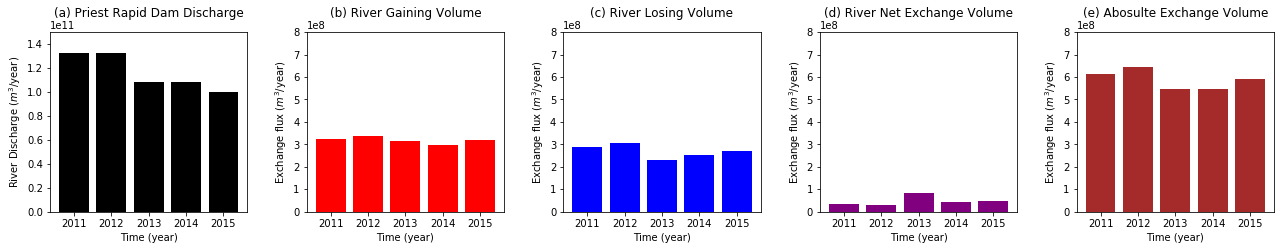

In [30]:
%matplotlib inline
start_year = 2011
# fig_name = fig_face_flux
gs = gridspec.GridSpec(1, 5)
fig = plt.figure()

ax0 = fig.add_subplot(gs[0, 0])
ax0.bar(start_year + np.arange(n_segment), discharge_flow, color="black")
ax0.set_ylim([0, 1.5e11])
ax0.set_xlabel('Time (year)')
ax0.set_ylabel('River Discharge ($m^3$/year)')
ax0.set_title("(a) Priest Rapid Dam Discharge", y=1.05)

ax1 = fig.add_subplot(gs[0, 1])
ax1.bar(start_year + np.arange(n_segment), out_flow, color="red")
ax1.set_ylim([0, 8e8])
ax1.set_xlabel('Time (year)')
ax1.set_ylabel('Exchange flux ($m^3$/year)')
ax1.set_title("(b) River Gaining Volume", y=1.05)

ax2 = fig.add_subplot(gs[0, 2])
ax2.bar(start_year + np.arange(n_segment), -in_flow, color="blue")
ax2.set_ylim([0, 8e8])
ax2.set_xlabel('Time (year)')
ax2.set_ylabel('Exchange flux ($m^3$/year)')
ax2.set_title("(c) River Losing Volume", y=1.05)

ax3 = fig.add_subplot(gs[0, 3])
ax3.bar(start_year + np.arange(n_segment), sum_flow, color="purple")
ax3.set_ylim([0, 8e8])
ax3.set_xlabel('Time (year)')
ax3.set_ylabel('Exchange flux ($m^3$/year)')
ax3.set_title("(d) River Net Exchange Volume", y=1.05)

ax4 = fig.add_subplot(gs[0, 4])
ax4.bar(start_year + np.arange(n_segment), abs_flow, color="brown")
ax4.set_ylim([0, 8e8])
ax4.set_xlabel('Time (year)')
ax4.set_ylabel('Exchange flux ($m^3$/year)')
ax4.set_title("(e) Abosulte Exchange Volume", y=1.05)

fig.tight_layout()
fig.subplots_adjust(left=0.1,
                    right=0.95,
                    bottom=0.07,
                    top=0.85,
                    wspace=0.30,
                    hspace=0.38
                    )
fig.set_size_inches(20, 3.2)

In [31]:
fig.savefig(fig_face_flux, dpi=300, transparent=False)
plt.close(fig)

## save flux metrix data

In [32]:
flux_metrix = pd.DataFrame(data = {'sum_flow' : sum_flow, 'abs_flow' : abs_flow, 'in_flow' : in_flow, 'out_flow' : out_flow })

flux_metrix.to_csv(out_dir + 'face_flux/flux_metrix.csv')

# plot face flux snapshot

In [10]:
# load pre-processed file
with open(fname_pickle, "rb") as f:
    out_flux = pickle.load(f)
# times = np.sort(list(out_flux.keys()))
# simu_time = np.sort([np.float(i[5:19]) for i in times])  ## why i[5:19] ??

In [11]:
# add three lines to contour indicating mass1 location
line1 = section_coord[0, 1:3] / 1000
line2 = section_coord[int(len(section_coord[:, 1]) / 2), 1:3] / 1000
line3 = section_coord[-1, 1:3] / 1000
line1_x = [line1[0]] * 2
line1_y = [line1[1] - 5, line1[1] + 5]
line2_x = [line2[0] - 5, line2[0] + 5]
line2_y = [line2[1]] * 2
line3_x = [line3[0] - 5, line3[0] + 5]
line3_y = [line3[1]] * 2

[datetime.datetime(2010, 12, 7, 0, 0)]


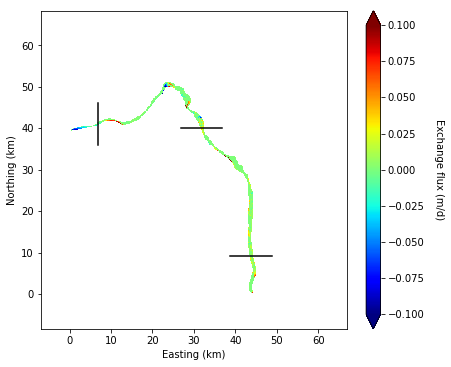

In [27]:
for itime in list(out_flux.keys())[:1]:
    #    itime = "Time:  " + "{:.5E}".format(itime) + " h"
    real_time = batch_delta_to_time(
        date_origin, [float(itime[7:18])], "%Y-%m-%d %H:%M:%S", "hours")
    real_time = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in real_time]
    print(real_time)
    xy_flux = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    for i_unique in np.arange(n_unique):
        xy_flux[unique_xy[i_unique, 1],
                unique_xy[i_unique, 0]] = out_flux[itime][i_unique]
    
    fig_name = fig_face_snapshots + str(real_time[0]) + ".png"
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(line1_x, line1_y, "black")
    ax1.plot(line2_x, line2_y, "black")
    ax1.plot(line3_x, line3_y, "black")
    cf1 = ax1.imshow(xy_flux * 24 / dx[0] / dy[0],
                     cmap=plt.cm.jet,
                     origin="lower",
                     vmin=-0.1,
                     vmax=0.1,
                     extent=[(x[0] - 0.5 * dx[0]) / 1000,
                             (x[-1] + 0.5 * dx[0]) / 1000,
                             (y[0] - 0.5 * dy[0]) / 1000,
                             (y[-1] + 0.5 * dy[0]) / 1000]
                     )
    ax1.set_xlabel("Easting (km)")
    ax1.set_ylabel("Northing (km)")
    ax1.set_aspect("equal", "datalim")
    ax1.set_xlim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    ax1.set_ylim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    cb1 = plt.colorbar(cf1, extend="both")
    cb1.ax.set_ylabel("Exchange flux (m/d)", rotation=270, labelpad=20)
    fig.tight_layout()
    fig.set_size_inches(6.5, 5.5)
    fig.savefig(fig_name, dpi=600)
#     plt.close(fig)


# plot finger flux